In [1]:
import pandas as pd

df = pd.read_csv('/content/sample_data/milk_production.csv')
print(df.head())


     Month  Production
0  1962-01         589
1  1962-02         561
2  1962-03         640
3  1962-04         656
4  1962-05         727


In [3]:
import numpy as np

values = df['Production'].values

# Normalize data (important for LSTM)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
values_scaled = scaler.fit_transform(values.reshape(-1,1))

# Function to create sequences and labels
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 30
X, y = create_sequences(values_scaled, SEQ_LENGTH)

print(X.shape, y.shape)  # (samples, timesteps, features)

(138, 30, 1) (138, 1)


In [4]:
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]


In [13]:
pip install tensorflow

In [71]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(units=200, dropout=0.8, learning_rate=0.1):
    model = models.Sequential()
    model.add(layers.LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1))
    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['mse', 'mae']
    )
    return model


In [108]:
model = build_model(units=128, dropout=0.2, learning_rate=0.01)

history = model.fit(
    X_train, y_train,
    epochs=160,
    batch_size=20,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/160


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.1466 - mae: 0.3247 - mse: 0.1466 - val_loss: 0.0798 - val_mae: 0.2517 - val_mse: 0.0798
Epoch 2/160
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0424 - mae: 0.1671 - mse: 0.0424 - val_loss: 0.0252 - val_mae: 0.1201 - val_mse: 0.0252
Epoch 3/160
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0222 - mae: 0.1287 - mse: 0.0222 - val_loss: 0.0210 - val_mae: 0.1105 - val_mse: 0.0210
Epoch 4/160
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0239 - mae: 0.1302 - mse: 0.0239 - val_loss: 0.0188 - val_mae: 0.1045 - val_mse: 0.0188
Epoch 5/160
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0207 - mae: 0.1214 - mse: 0.0207 - val_loss: 0.0192 - val_mae: 0.1035 - val_mse: 0.0192
Epoch 6/160
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0156 - mae: 0.1042 - mse: 0.0156 - val_loss: 0.0145 - val_mae: 0.0911 - val_mse: 0.0145
Epoch 7/160
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0154 - mae: 0.1050 - mse: 0.0154 - val_loss: 0.0145 - val_mae: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
MSE: 270.0844
RMSE: 16.4342


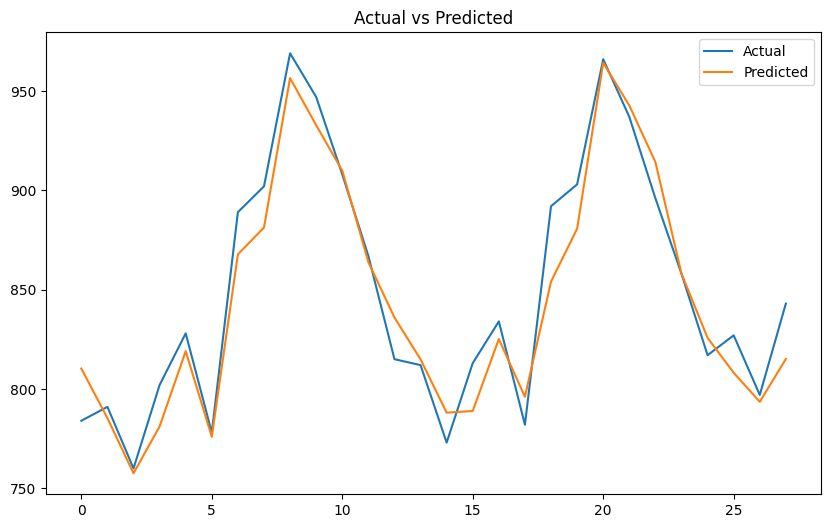

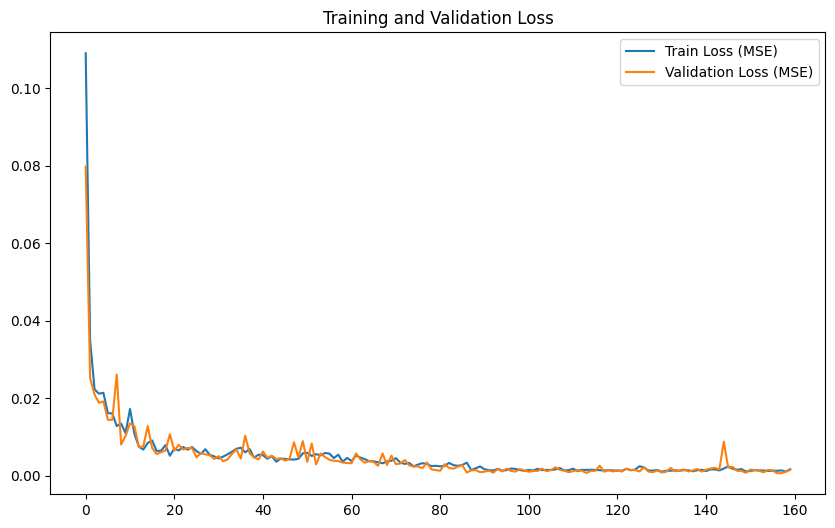

In [109]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Predict on validation data
y_pred = model.predict(X_val)

# Inverse transform to get original scale
y_val_orig = scaler.inverse_transform(y_val)
y_pred_orig = scaler.inverse_transform(y_pred)

# Calculate metrics
mse = mean_squared_error(y_val_orig, y_pred_orig)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.plot(y_val_orig, label='Actual')
plt.plot(y_pred_orig, label='Predicted')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
